# Using NLP to Predict the 2022 US Midterm Election Platforms using Twitter Data

## Introduction
Twitter is the modern political soapbox. We have all seen it used as a vehicle for both information and mis-information and this project aims to use tweets to identify the Democratic and Republican political platforms for the 2022 midterm elections in the United States.

Party platforms were once thought to be essential to the electoral process as they give the candidates a clear political position with which they can campaign. These platforms give voters a sense of what the candidates believe in, the issues they will focus on and if elected, how they will address them in their policy-making.

In the norm-breaking 2020 Presidential Election, the Republican party decided to not have any official platform other than to negate existing and proposed Democratic policies. 

This project hopes to use twitter data from the accounts of members from the 117th US Congress (Senators and Congressmen/women) and determine if / what the political platforms could be for the 2022 Midterm Elections. 

## Project Outline

- Acquire Twitter data
    - get account names of all congress teitter users
    - scrape last 1000 tweets from each user
- Clean data
    - extract: URLs, emojis, hashtags to be used in later analysis
    - remove: URLs, emojis, mentions, stop words, words with numbers, punctuation, special characters, text in brackets
    - transform: to all lower case, tokenize and lemmatize  
- Sentiment Analysis and Topic Modeling
    - score tweets using VADER, TextBlob and Flair models
    - get bigrams and trigrams
    - get topics using LSA, Corex and LDA
    - visualize topics using pyLDAvis
- Conclusion


In [76]:
%%time

import pandas as pd
import numpy as np
import seaborn as sns
import contractions
import matplotlib.pyplot as plt

import re

import nltk
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ['amp',
                'know',
                'say',
                'today',
                'start',
                'week',
                'want',
                'day',
                'talk',
                'new',
                'thank',
                'birthday',
                'wish',
                'happy',
                'el',
                'los',
                'la',
                'rt',
                'ive',
                'continue',
                'thanks',
                'th',
                'also',
                'town',
                'hall',
                'let',
                'us',
                'last',
                'proud',
                'join',
                'like',
                'congratulations',
                 'ago'                 
                ]

stopwords.extend(new_stopwords)



from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union(new_stopwords)

pd.options.display.max_colwidth = 600
pd.options.display.max_columns=500


import spacy 
nlp = spacy.load("en_core_web_lg")


from textblob import TextBlob
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.sklearn


import pickle 


import tqdm
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

Wall time: 1.02 s


In [77]:
### load data
#df = pd.read_csv('data/df_with_reach.csv')
#df.shape

In [78]:
## load data
df = pd.read_pickle('congress_cleaned_stage1.pickle')
df.shape

(557974, 9)

In [79]:
## Filter dates from 2021-2022

start_date = '2021-01-01 00:00:00+00:00'
end_date   = '2022-01-20 00:00:00+00:00'
mask = (df['Date'] > start_date) & (df['Date'] <= end_date)

df= df.loc[mask]
df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 456033 entries, 5 to 557617
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   User          456033 non-null  object             
 1   Content       456033 non-null  object             
 2   Date          456033 non-null  datetime64[ns, UTC]
 3   Favs          456033 non-null  object             
 4   RTs           456033 non-null  object             
 5   Location      456033 non-null  object             
 6   Name          456033 non-null  object             
 7   Party         456033 non-null  object             
 8   cleaned_text  456033 non-null  object             
dtypes: datetime64[ns, UTC](1), object(8)
memory usage: 34.8+ MB


## Distribution of data by Party

In [80]:
df.Party.value_counts()

D    289251
R    166782
Name: Party, dtype: int64

## Cleaning text 

In [81]:
%%time

def removeRT(text):
    RTless = lambda x: re.compile(r'\#').sub('', re.compile('RT @').sub('@', x, count=1).strip())
    return (RTless(text))


# remove RT 
df['processed'] = df['Content'].apply(removeRT)

# remove urls 
df['processed'] = df['processed'].replace(r'http\S+', ' ', regex=True)


#contractions
df['processed']=df['processed'].apply(contractions.fix)

# convert to lowercase
df['processed']=df['processed'].str.lower()

## removing account names -- basically after @ words -- those are usernames

df['processed']=df['processed'].apply(lambda x :[t for t in x.split() if not t.startswith('@')] ).apply(lambda x: ' '.join(x))
#df['processed'].head(5)

## removing special characters 
df['processed'] = df['processed'].replace(r'[^A-Za-z]+', ' ', regex=True)

##removing extra spaces 
df['processed']=df['processed'].apply(lambda x : x.strip())

## removing stopwords
#stop_words = text.ENGLISH_STOP_WORDS.union(new_stopwords)

df['processed'] = df['processed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

print('Shape of dataset',df.shape)

## removing completely blank records 
df=df[df['processed']!='']

print('After removing empty records, shape of the dataset',df.shape)

Shape of dataset (456033, 10)
After removing empty records, shape of the dataset (451128, 10)
Wall time: 20.9 s


## Begin experiment with LDA Topic Modeling

In [82]:
%%time
# create a copy of the dataset
df_LDA = df.copy()

Wall time: 74.8 ms


## Vectorize the text with CountVectorizer

In [90]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.95, # minimum required occurences of a word 
                             min_df=35, # maximum required occurences of a word 
                             max_features=6000,
                             analyzer='word',  
                             ngram_range=(1,2),
                             stop_words=set(stop_words),# remove stop words                             
                             token_pattern=r'\w+|\$[\d\.]+|\S+')

dtm = vectorizer.fit_transform(df['processed'])


tf_feature_names = vectorizer.get_feature_names_out()



Wall time: 9.09 s


## Create the LDA model

In [91]:
%%time
# creating NMF model with 10 components/topics

lda_model = LatentDirichletAllocation(n_components=7, # Number of topics
                                      learning_method='online',
                                      random_state=20,       
                                      n_jobs = -1  # Use all available CPUs
                                      )

# fitting and transforming the dtm to obtain weights corresponding to 'belongingness' of document to each topic
lda_topics=lda_model.fit_transform(dtm)

Wall time: 12min 46s


In [154]:
for i in lda_topics[-10:]:
    x = i.argsort().tolist()
    print(i[0])

0.023809524423542266
0.46753309410298216
0.23801628051815962
0.014293876991401243
0.4353640601863198
0.30597348433454047
0.028571429000794166
0.012987013910466673
0.017923971814589875
0.015873016055117154


## Display Topics and weights

In [92]:
%%time
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 10
display_topics(lda_model, tf_feature_names, no_top_words)

Wall time: 3.99 ms


,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights
0,jobs,8216.5,help,13580.2,biden,13908.1,covid,20327.3,house,16218.5,great,12106.5,women,9592.3
1,pandemic,8178.3,right,9648.8,congress,13059.4,families,16148.7,act,11850.3,working,10693.0,family,7777.2
2,million,7688.7,state,8626.3,president,12517.1,people,8847.6,health,11813.7,year,10291.7,country,7538.3
3,buildbackbetter,7531.5,rights,7777.9,legislation,7259.4,vaccine,8093.1,bipartisan,11019.2,better,6779.9,support,7173.2
4,funding,6605.9,need,7386.1,democrats,6704.4,protect,7541.9,infrastructure,9307.3,veterans,6390.9,lives,6919.7
5,act,6551.3,pass,7072.1,workers,6239.9,good,7298.0,passed,7993.7,crisis,6266.2,years,6214.5
6,school,5167.2,joined,7012.1,americans,5654.4,american,7160.1,vote,7823.1,yesterday,6088.5,voted,5949.7
7,tax,5021.5,plan,6945.3,president biden,5387.3,safe,5890.2,law,7285.5,nation,6003.3,public,5703.6
8,critical,5014.9,american,6892.4,administration,5224.0,celebrate,5660.5,discuss,6124.7,build,5513.3,lost,4544.7
9,students,4661.0,work,6210.7,climate,5147.2,democracy,5422.7,live,6060.2,month,5415.1,small,4477.5


## Assign topics to each tweet


In [103]:
## assign topics to each tweet
df_LDA['LDA_Topic']=lda_topics.argmax(axis=1)

## Naming topics 
naming={0:'Economy',
        1:'Help',
        2:'Biden Administration',
        3:'Covid Relief',
        4:'Legislation',
        5:'Jobs',
        6:'Family Support',
        }

df_LDA['LDA_Topic_name']=df_LDA['LDA_Topic'].map(naming)

df_LDA

,User,Content,Date,Favs,RTs,Location,Name,Party,cleaned_text,processed,LDA_Topic,Topic_name,LDA_Topic_name
5,SenJohnBarrasso,RT @senrobportman: I am deeply troubled by @POTUS' comment insinuating that a Russian invasion may just be “a minor incursion.” \n\nThis is t…,2022-01-19 23:19:01+00:00,0,146,,"Barrasso, John",R,senrobportman i am deeply troubled by potus comment insinuating that a russian invasion may just be a minor incursion this is t,deeply troubled comment insinuating russian invasion may minor incursion,3,Covid Relief,Covid Relief
6,SenJohnBarrasso,If @JoeBiden wants to ever pull back from this failing presidency he needs to start focusing on the things that the… https://t.co/YWRBK0mpaR,2022-01-19 21:58:05+00:00,109,31,,"Barrasso, John",R,if joebiden wants to ever pull back from this failing presidency he needs to start focusing on the things that the,wants ever pull back failing presidency needs focusing things,6,Family Support,Family Support
7,SenJohnBarrasso,RT @SenateGOP: 🚨 BREAKING 🚨 \n\nCourt docs show show migrant encounters at the southern border increased again in December. \n\nAnd are showing…,2022-01-19 19:50:03+00:00,0,18,,"Barrasso, John",R,senategop breaking court docs show show migrant encounters at the southern border increased again in december and are showing,breaking court docs show show migrant encounters southern border increased december showing,5,Jobs,Jobs
8,SenJohnBarrasso,RT @WYOEducation: Cameron Nicholas Reckard and Tamica Lee Smith of #Sheridan will join @SenJohnBarrasso and @SenLummis in representing Wyom…,2022-01-18 20:56:53+00:00,0,2,,"Barrasso, John",R,wyoeducation cameron nicholas reckard and tamica lee smith of sheridan will join senjohnbarrasso and senlummis in representing wyom,cameron nicholas reckard tamica lee smith sheridan representing wyom,1,Help,Help
9,SenJohnBarrasso,"RT @SenHydeSmith: I am seeing a lot of my colleagues claim that the filibuster is anti-democratic.\nNo, silencing half of Americans is anti-…",2022-01-18 20:30:51+00:00,0,83,,"Barrasso, John",R,senhydesmith i am seeing a lot of my colleagues claim that the filibuster is antidemocraticno silencing half of americans is anti,seeing lot colleagues claim filibuster anti democratic silencing half americans anti,2,Biden Administration,Biden Administration
...,...,...,...,...,...,...,...,...,...,...,...,...,...
557613,RepJohnYarmuth,2021 is also bringing us the continued dominance of @UofLWBB. @CoachJeffWalz’s team is crushing it as usual. Best b… https://t.co/c3tczF8WZO,2021-01-03 02:17:31+00:00,97,7,"Louisville, KY","Yarmuth, John A.",D,is also bringing us the continued dominance of uoflwbb coachjeffwalzs team is crushing it as usual best b,bringing continued dominance team crushing usual best b,4,Legislation,Legislation
557614,RepJohnYarmuth,Congratulations to @UKFootball on their @taxslayerbowl victory today. Second biggest win of the day after… https://t.co/7QIno4F2QX,2021-01-02 22:37:56+00:00,120,7,"Louisville, KY","Yarmuth, John A.",D,congratulations to ukfootball on their taxslayerbowl victory today second biggest win of the day after,victory second biggest win,2,Biden Administration,Biden Administration
557615,RepJohnYarmuth,"I feel compelled to note that the Senate Majority Leader referring to $2,000 survival checks as “socialism for rich… https://t.co/6B63SdkU6S",2021-01-01 23:59:58+00:00,360,77,"Louisville, KY","Yarmuth, John A.",D,i feel compelled to note that the senate majority leader referring to survival checks as socialism for rich,feel compelled note senate majority leader referring survival checks socialism rich,4,Legislation,Legislation
557616,RepJohnYarmuth,"If Mitch doesn’t want to send out $2,000 checks to Americans, just call them tax rebates. Republicans will eat that up.",2021-01-01 16:21:16+00:00,376,61,"Louisville, KY","Yarmuth, John A.",D,if mitch doesnt want to send out checks to americans just call them tax rebates republicans will eat that up,mitch send checks americans call tax reba

## Plotting LDA TOPIC Distribution

C:\Users\emich\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\emich\AppData\Roaming\Python\Python39\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


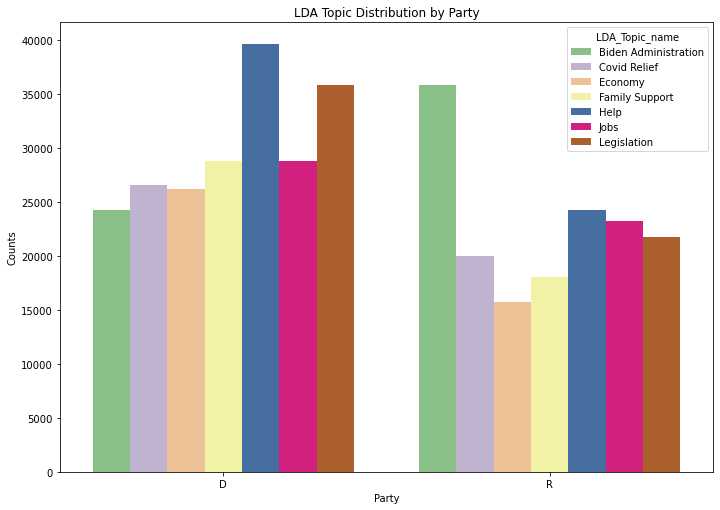

In [157]:


a4_dims = (11.7, 8.27)

#palette = ['tab:red', 'tab:blue', 'tab:green']

x = df.groupby(['LDA_Topic_name','Party']).size().to_frame('LDA_Topic_name.value_counts()').reset_index()
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x='Party', y='LDA_Topic_name.value_counts()', hue='LDA_Topic_name', data=x,  palette='Accent').set(title='LDA Topic Distribution by Party')
ax.set(xlabel='Party', ylabel='Counts')
plt.show()

## sanity check: save df before continuing

In [95]:
df_LDA.to_csv('data/df_LDA.csv', encoding='UTF-8', index=False)

In [96]:
# copy df
df = df_LDA.copy()

## Begin experiment with NMF Topic Modeling

In [97]:
## Creating document term matrix using TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.95,
                        min_df=3,
                        stop_words=stopwords,
                        ngram_range=(1,2))
dtm = tfidf.fit_transform(df['processed'])

tf_feature_names = tfidf.get_feature_names_out()

dtm       

<451128x276604 sparse matrix of type '<class 'numpy.float64'>'
	with 6493872 stored elements in Compressed Sparse Row format>

In [98]:
%%time
# creating NMF model with 10 components/topics

nmf_model = NMF(n_components=7, 
                random_state=20,
                init='nndsvd',
                #n_jobs = -1  # Use all available CPUs
                )

# fitting and transforming the dtm to obtain weights corresponding to 'belongingness' of document to each topic
topics=nmf_model.fit_transform(dtm)

Wall time: 15.3 s


In [153]:
for i in topics[-10:]:
    x = i.argsort().tolist()
    print(i[0])

0.0006949444721145628
0.008784309213208491
0.0016849449992128954
0.007434646451630068
0.004465675857942767
0.004229159463774311
0.000996014039116884
0.00026199147560261203
0.0017970153736370106
0.006594372741645043


## show topic weights for each word

In [101]:
%%time
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 10
display_topics(nmf_model, tf_feature_names, no_top_words)

Wall time: 159 ms


,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights
0,covid,2.4,biden,3.2,infrastructure,2.6,back,2.2,house,1.5,american,2.2,health,2.5
1,get,1.6,president,2.1,bipartisan,1.8,build,1.9,act,1.4,plan,1.1,care,2.2
2,great,1.6,president biden,1.6,bipartisan infrastructure,1.4,better,1.9,rights,1.0,families,0.9,health care,1.4
3,vaccine,1.4,border,0.9,bill,1.3,build back,1.8,voting,1.0,rescue,0.9,child,0.6
4,year,1.1,administration,0.9,infrastructure bill,0.9,back better,1.7,voting rights,0.8,american rescue,0.9,affordable,0.5
5,work,1.1,biden administration,0.8,jobs,0.9,better act,0.9,vote,0.8,rescue plan,0.9,child care,0.5
6,one,1.0,joe,0.7,investment,0.8,act,0.7,senate,0.7,tax,0.8,mental,0.5
7,time,1.0,joe biden,0.7,infrastructure investment,0.6,agenda,0.3,passed,0.7,people,0.8,mental health,0.5
8,covid vaccine,0.9,crisis,0.7,law,0.6,better agenda,0.2,pass,0.6,american people,0.6,access,0.5
9,country,0.8,southern,0.3,investment jobs,0.6,pass build,0.2,right,0.5,child,0.5,coverage,0.3


In [ ]:
%%time
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

## Assign topics to each tweet

In [105]:

df['NMF_Topic']=topics.argmax(axis=1)

## Naming topics 

naming={0:'Covid',
        1:'Biden Presidency',
        2:'Infrastructure',
        3:'Build Back Better Act',
        4:'Voting Legislation',
        5:'American Rescue Plan',
        6:'Healthcare'
       }

df['NMF_Topic_name']=df['NMF_Topic'].map(naming)

df

,User,Content,Date,Favs,RTs,Location,Name,Party,cleaned_text,processed,LDA_Topic,LDA_Topic_name,NMF_Topic,NMF_Topic_name
5,SenJohnBarrasso,RT @senrobportman: I am deeply troubled by @POTUS' comment insinuating that a Russian invasion may just be “a minor incursion.” \n\nThis is t…,2022-01-19 23:19:01+00:00,0,146,,"Barrasso, John",R,senrobportman i am deeply troubled by potus comment insinuating that a russian invasion may just be a minor incursion this is t,deeply troubled comment insinuating russian invasion may minor incursion,3,Covid Relief,0,Covid
6,SenJohnBarrasso,If @JoeBiden wants to ever pull back from this failing presidency he needs to start focusing on the things that the… https://t.co/YWRBK0mpaR,2022-01-19 21:58:05+00:00,109,31,,"Barrasso, John",R,if joebiden wants to ever pull back from this failing presidency he needs to start focusing on the things that the,wants ever pull back failing presidency needs focusing things,6,Family Support,3,Build Back Better Act
7,SenJohnBarrasso,RT @SenateGOP: 🚨 BREAKING 🚨 \n\nCourt docs show show migrant encounters at the southern border increased again in December. \n\nAnd are showing…,2022-01-19 19:50:03+00:00,0,18,,"Barrasso, John",R,senategop breaking court docs show show migrant encounters at the southern border increased again in december and are showing,breaking court docs show show migrant encounters southern border increased december showing,5,Jobs,1,Biden Presidency
8,SenJohnBarrasso,RT @WYOEducation: Cameron Nicholas Reckard and Tamica Lee Smith of #Sheridan will join @SenJohnBarrasso and @SenLummis in representing Wyom…,2022-01-18 20:56:53+00:00,0,2,,"Barrasso, John",R,wyoeducation cameron nicholas reckard and tamica lee smith of sheridan will join senjohnbarrasso and senlummis in representing wyom,cameron nicholas reckard tamica lee smith sheridan representing wyom,1,Help,0,Covid
9,SenJohnBarrasso,"RT @SenHydeSmith: I am seeing a lot of my colleagues claim that the filibuster is anti-democratic.\nNo, silencing half of Americans is anti-…",2022-01-18 20:30:51+00:00,0,83,,"Barrasso, John",R,senhydesmith i am seeing a lot of my colleagues claim that the filibuster is antidemocraticno silencing half of americans is anti,seeing lot colleagues claim filibuster anti democratic silencing half americans anti,2,Biden Administration,4,Voting Legislation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557613,RepJohnYarmuth,2021 is also bringing us the continued dominance of @UofLWBB. @CoachJeffWalz’s team is crushing it as usual. Best b… https://t.co/c3tczF8WZO,2021-01-03 02:17:31+00:00,97,7,"Louisville, KY","Yarmuth, John A.",D,is also bringing us the continued dominance of uoflwbb coachjeffwalzs team is crushing it as usual best b,bringing continued dominance team crushing usual best b,4,Legislation,0,Covid
557614,RepJohnYarmuth,Congratulations to @UKFootball on their @taxslayerbowl victory today. Second biggest win of the day after… https://t.co/7QIno4F2QX,2021-01-02 22:37:56+00:00,120,7,"Louisville, KY","Yarmuth, John A.",D,congratulations to ukfootball on their taxslayerbowl victory today second biggest win of the day after,victory second biggest win,2,Biden Administration,0,Covid
557615,RepJohnYarmuth,"I feel compelled to note that the Senate Majority Leader referring to $2,000 survival checks as “socialism for rich… https://t.co/6B63SdkU6S",2021-01-01 23:59:58+00:00,360,77,"Louisville, KY","Yarmuth, John A.",D,i feel compelled to note that the senate majority leader referring to survival checks as socialism for rich,feel compelled note senate majority leader referring survival checks socialism rich,4,Legislation,4,Voting Legislation
557616,RepJohnYarmuth,"If Mitch doesn’t want to send out $2,000 checks to Americans, just call them tax rebates. Republicans will eat that up.",2021-01-01 16:21:16+00:00,376,61,"Louisville, KY","Yarmuth, John A.",D,if mitch doesnt want to send out checks to americans just call them tax rebates republicans will eat that up,mitch send

## Plotting NMF TOPIC Distribution

C:\Users\emich\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\emich\AppData\Roaming\Python\Python39\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


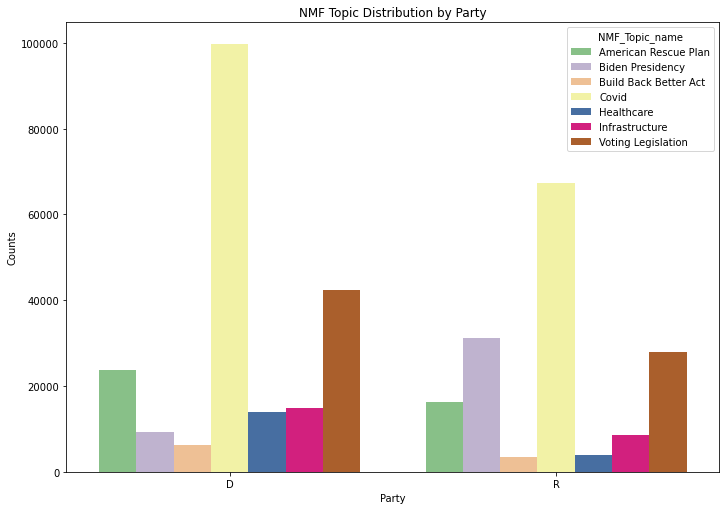

In [158]:


a4_dims = (11.7, 8.27)

#palette = ['tab:red', 'tab:blue', 'tab:green']

x = df.groupby(['NMF_Topic_name','Party']).size().to_frame('NMF_Topic_name.value_counts()').reset_index()
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x='Party', y='NMF_Topic_name.value_counts()', hue='NMF_Topic_name', data=x,  palette='Accent').set(title='NMF Topic Distribution by Party')
ax.set(xlabel='Party', ylabel='Counts')
plt.show()


## Sanity Check: Save data and model for later use

In [106]:
## Write out data
df.to_pickle('data/NMF_LDA_df.pickle')
df.to_csv('data/NMF_LDA_df.csv', encoding='utf-8', index=False)

In [107]:
## Save model for use later
filename1 = 'models/nmf_model.sav'
pickle.dump(nmf_model, open(filename1, 'wb'))

filename2 = 'models/lda_model.sav'
pickle.dump(lda_model, open(filename2, 'wb'))

'''
# load the model from disk
nmf_model = pickle.load(open('models/nmf_model.sav', 'rb'))
topics=nmf_model.fit_transform(dtm)
dtm
'''


"\n# load the model from disk\nnmf_model = pickle.load(open('models/nmf_model.sav', 'rb'))\ntopics=nmf_model.fit_transform(dtm)\ndtm\n"

## Let's subset by Party tweets
- This will show us what topics each party is talking about more.
- These individual lists can be suitable party platform topics


In [109]:
df[df.Party=='R'].LDA_Topic_name.value_counts()

Biden Administration    37381
Help                    24770
Jobs                    24078
Legislation             22487
Covid Relief            20883
Family Support          18511
Economy                 16281
Name: LDA_Topic_name, dtype: int64

In [110]:
df[df.Party=='D'].LDA_Topic_name.value_counts()

Help                    53847
Legislation             49249
Family Support          39614
Jobs                    39216
Covid Relief            35997
Economy                 35824
Biden Administration    32990
Name: LDA_Topic_name, dtype: int64

In [112]:
df[df.Party=='R'].NMF_Topic_name.value_counts()

Covid                    68722
Biden Presidency         32902
Voting Legislation       29197
American Rescue Plan     17166
Infrastructure            8852
Healthcare                3930
Build Back Better Act     3622
Name: NMF_Topic_name, dtype: int64

In [111]:
df[df.Party=='D'].NMF_Topic_name.value_counts()

Covid                    135432
Voting Legislation        58721
American Rescue Plan      32696
Infrastructure            19891
Healthcare                19073
Biden Presidency          12551
Build Back Better Act      8373
Name: NMF_Topic_name, dtype: int64

## Lets look at n-grams 

In [113]:
def get_top_n_gram(corpus,ng_range, ntype, n=None):
    vec = CountVectorizer(stop_words=set(stop_words),ngram_range=ng_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    ngrams = pd.DataFrame(words_freq[:n],columns = [ntype , 'count'])
    return ngrams

## Get top n-grams for each party and for entire dataframe

In [114]:

all_bigrams_df  = get_top_n_gram(df.processed, (2,2),'All Tweet Bigrams',10)
all_trigrams_df = get_top_n_gram(df.processed, (3,3),'All Tweet Trigrams',10)

GOP_bigrams     = get_top_n_gram(df[df.Party=='R'].processed, (2,2),'Republican Bigrams',10)
DEM_bigrams     =  get_top_n_gram(df[df.Party=='D'].processed, (2,2),'Democrat Bigrams',10)

GOP_trigrams    = get_top_n_gram(df[df.Party=='R'].processed, (3,3),'Republican Trigrams',10)
DEM_trigrams    =  get_top_n_gram(df[df.Party=='D'].processed, (3,3),'Democrat Trigrams',10)

In [115]:
GOP_trigrams

,Republican Trigrams,count
0,crisis southern border,461
1,chinese communist party,405
2,brave men women,397
3,biden border crisis,354
4,biden vaccine mandate,345
5,critical race theory,321
6,supply chain crisis,312
7,tax spending spree,294
8,law enforcement officers,289
9,border patrol agents,229


In [116]:
DEM_trigrams

,Democrat Trigrams,count
0,american rescue plan,2104
1,child tax credit,1449
2,build better act,1281
3,infrastructure investment jobs,923
4,investment jobs act,876
5,bipartisan infrastructure law,771
6,john lewis voting,643
7,lewis voting rights,602
8,good paying jobs,574
9,martin luther king,480


In [ ]:
#isolate tweets with specific trigram
#df[df.processed.str.contains('american rescue plan')]

## Save N-grams for later use

In [117]:
all_bigrams_df.to_csv('data/all_bigrams_df.csv', encoding='utf-8', index=False) 
all_trigrams_df.to_csv('data/all_trigrams_df.csv', encoding='utf-8', index=False) 
GOP_bigrams.to_csv('data/GOP_bigrams.csv', encoding='utf-8', index=False)     
DEM_bigrams.to_csv('data/DEM_bigrams.csv', encoding='utf-8', index=False)     
GOP_trigrams.to_csv('data/GOP_trigrams.csv', encoding='utf-8', index=False)    
DEM_trigrams.to_csv('data/DEM_trigrams.csv', encoding='utf-8', index=False)    

In [ ]:
for i in DEM_trigrams['Democrat Trigrams']:
    print(i)

# Let's move on to Sentiment Analysis

## Using TextBlob

In [118]:


df.drop_duplicates(subset ='Content', keep = 'first', inplace = True)
df['Content'] = df['Content'].astype('str')

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df['Polarity']     = df['Content'].progress_apply(get_polarity)
df['Subjectivity'] = df['Content'].progress_apply(get_subjectivity)


100%|██████████| 369256/369256 [01:05<00:00, 5654.73it/s]


<AxesSubplot:title={'center':'TextBlob Sentiment Analysis'}>

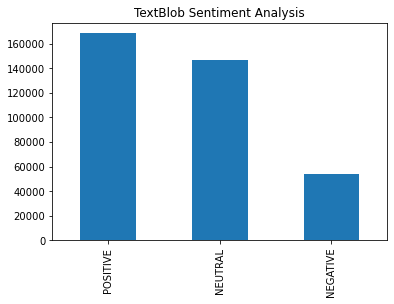

In [119]:
## create the Textblob_Sentiment
df['Textblob_Sentiment']=''

## interpret Polarity to determine sentiment
df.loc[df.Polarity>0,'Textblob_Sentiment']='POSITIVE'
df.loc[df.Polarity==0,'Textblob_Sentiment']='NEUTRAL'
df.loc[df.Polarity<0,'Textblob_Sentiment']='NEGATIVE'


## plot the distribution of sentiment
df.Textblob_Sentiment.value_counts().plot(kind='bar',title="TextBlob Sentiment Analysis")

C:\Users\emich\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


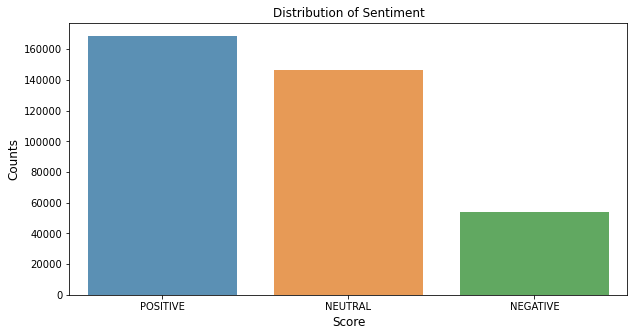

In [120]:
## another plot to see the distribution
import seaborn as sns
senti_count  = df['Textblob_Sentiment'].value_counts()
senti_count = senti_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(senti_count.index, senti_count.values, alpha=0.8)
plt.title('Distribution of Sentiment')
plt.ylabel('Counts', fontsize=12)
plt.xlabel('Score', fontsize=12)
plt.show()

array([<AxesSubplot:title={'center':'D'}, xlabel='Textblob_Sentiment'>,
       <AxesSubplot:title={'center':'R'}, xlabel='Textblob_Sentiment'>],
      dtype=object)

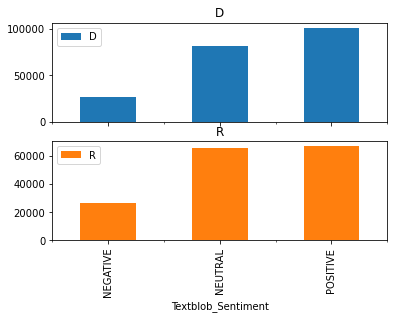

In [121]:
(pd.crosstab(df['Textblob_Sentiment'], df['Party'])
    .plot.bar(subplots=True)
)

C:\Users\emich\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\emich\AppData\Roaming\Python\Python39\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


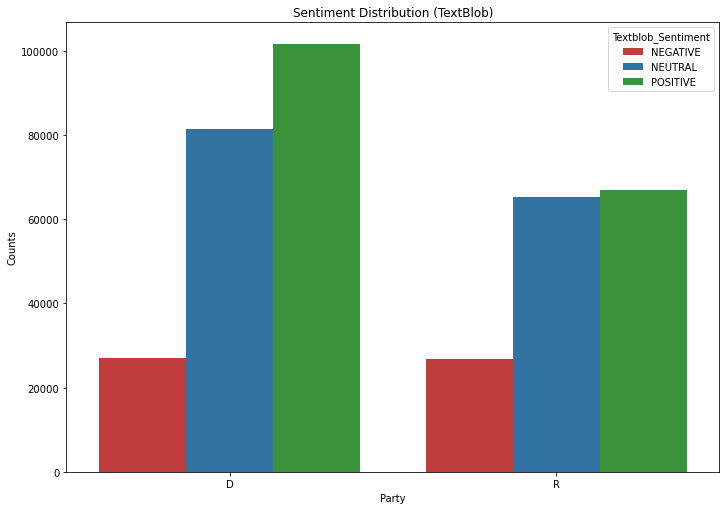

In [122]:
## Plotting TextBlob Sentiment

a4_dims = (11.7, 8.27)

palette = ['tab:red', 'tab:blue', 'tab:green']

x = df.groupby(['Textblob_Sentiment','Party']).size().to_frame('Textblob_Sentiment.value_counts()').reset_index()
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x='Party', y='Textblob_Sentiment.value_counts()', hue='Textblob_Sentiment', data=x,  palette=palette).set(title='Sentiment Distribution (TextBlob)')
ax.set(xlabel='Party', ylabel='Counts')
plt.show()

In [124]:
## Write out data
df.to_pickle('pickles/topics_and_textblob.pickle')
df.to_csv('data/topics_and_textblob.csv', encoding='utf-8', index=False)

## Using VADER

In [125]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\emich\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [126]:
# Get scores of each Tweet
df['VADER_Scores'] = df['Content'].apply(lambda Description: sid.polarity_scores(Description))


In [127]:
# Aggregate those scored to get the compound score 
df['compound'] = df['VADER_Scores'].apply(lambda score_dict: score_dict['compound'])
df['VADER_sentiment']=''
df.loc[df.compound>0,'VADER_sentiment']='POSITIVE'
df.loc[df.compound==0,'VADER_sentiment']='NEUTRAL'
df.loc[df.compound<0,'VADER_sentiment']='NEGATIVE'

In [128]:
df.head()

,User,Content,Date,Favs,RTs,Location,Name,Party,cleaned_text,processed,LDA_Topic,LDA_Topic_name,NMF_Topic,NMF_Topic_name,Polarity,Subjectivity,Textblob_Sentiment,VADER_Scores,compound,VADER_sentiment
5,SenJohnBarrasso,RT @senrobportman: I am deeply troubled by @POTUS' comment insinuating that a Russian invasion may just be “a minor incursion.” \n\nThis is t…,2022-01-19 23:19:01+00:00,0,146,,"Barrasso, John",R,senrobportman i am deeply troubled by potus comment insinuating that a russian invasion may just be a minor incursion this is t,deeply troubled comment insinuating russian invasion may minor incursion,3,Covid Relief,0,Covid,-0.183333,0.400000,NEGATIVE,"{'neg': 0.141, 'neu': 0.859, 'pos': 0.0, 'compound': -0.5095}",-0.5095,NEGATIVE
6,SenJohnBarrasso,If @JoeBiden wants to ever pull back from this failing presidency he needs to start focusing on the things that the… https://t.co/YWRBK0mpaR,2022-01-19 21:58:05+00:00,109,31,,"Barrasso, John",R,if joebiden wants to ever pull back from this failing presidency he needs to start focusing on the things that the,wants ever pull back failing presidency needs focusing things,6,Family Support,3,Build Back Better Act,0.100000,0.050000,POSITIVE,"{'neg': 0.156, 'neu': 0.844, 'pos': 0.0, 'compound': -0.596}",-0.5960,NEGATIVE
7,SenJohnBarrasso,RT @SenateGOP: 🚨 BREAKING 🚨 \n\nCourt docs show show migrant encounters at the southern border increased again in December. \n\nAnd are showing…,2022-01-19 19:50:03+00:00,0,18,,"Barrasso, John",R,senategop breaking court docs show show migrant encounters at the southern border increased again in december and are showing,breaking court docs show show migrant encounters southern border increased december showing,5,Jobs,1,Biden Presidency,0.000000,0.000000,NEUTRAL,"{'neg': 0.0, 'neu': 0.9, 'pos': 0.1, 'compound': 0.2732}",0.2732,POSITIVE
8,SenJohnBarrasso,RT @WYOEducation: Cameron Nicholas Reckard and Tamica Lee Smith of #Sheridan will join @SenJohnBarrasso and @SenLummis in representing Wyom…,2022-01-18 20:56:53+00:00,0,2,,"Barrasso, John",R,wyoeducation cameron nicholas reckard and tamica lee smith of sheridan will join senjohnbarrasso and senlummis in representing wyom,cameron nicholas reckard tamica lee smith sheridan representing wyom,1,Help,0,Covid,0.000000,0.000000,NEUTRAL,"{'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'compound': 0.296}",0.2960,POSITIVE
9,SenJohnBarrasso,"RT @SenHydeSmith: I am seeing a lot of my colleagues claim that the filibuster is anti-democratic.\nNo, silencing half of Americans is anti-…",2022-01-18 20:30:51+00:00,0,83,,"Barrasso, John",R,senhydesmith i am seeing a lot of my colleagues claim that the filibuster is antidemocraticno silencing half of americans is anti,seeing lot colleagues claim filibuster anti democratic silencing half americans anti,2,Biden Administration,4,Voting Legislation,-0.166667,0.166667,NEGATIVE,"{'neg': 0.163, 'neu': 0.837, 'pos': 0.0, 'compound': -0.4019}",-0.4019,NEGATIVE


In [129]:
## make a backup of the df
df.to_pickle('pickles/df_with_vader_textblob_scores.pickle')
df.to_csv('data/df_with_vader_textblob_scores.csv', encoding='utf-8', index=False)

C:\Users\emich\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\emich\AppData\Roaming\Python\Python39\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


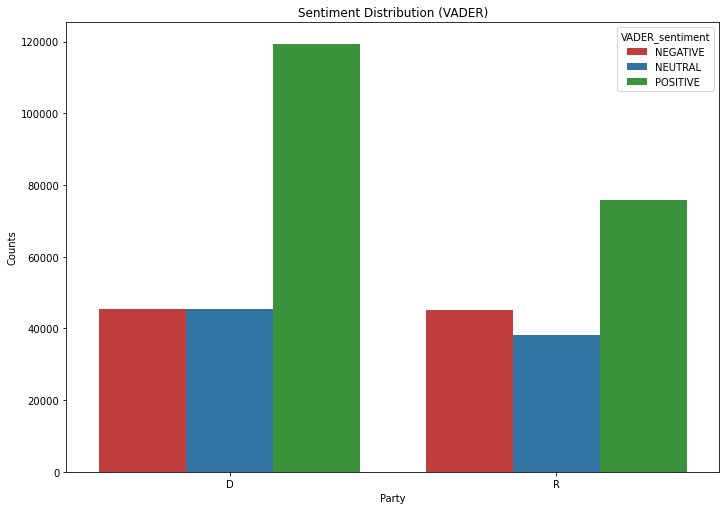

In [130]:
## Plotting VADER Sentiment

a4_dims = (11.7, 8.27)

palette = ['tab:red', 'tab:blue', 'tab:green']

x = df.groupby(['VADER_sentiment','Party']).size().to_frame('VADER_sentiment.value_counts()').reset_index()
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x='Party', y='VADER_sentiment.value_counts()', hue='VADER_sentiment', data=x,  palette=palette).set(title='Sentiment Distribution (VADER)')
ax.set(xlabel='Party', ylabel='Counts')
plt.show()

## Determine 'Reach' 
- 'Reach' is an aggregate of retweets(RTs) and favorites(Faves) of a tweet with their values scaled then combined. The aggregate value represents how the twitterverse has reacted to a tweet.
- The higher the value of 'Reach', the more people are responding to the contents / topics of a tweet which could simulate how people would react to topics within a political platform or agenda
- weights of each are based on how 'viral' a tweet is- which would also mean more impact and 'Reach' with the audience. 

In [159]:
df.describe()

,LDA_Topic,NMF_Topic,Polarity,Subjectivity,compound
count,369256.000000,369256.000000,369256.000000,369256.000000,369256.000000
mean,2.968190,1.912210,0.127052,0.350724,0.168500
std,1.933918,2.111044,0.292883,0.322197,0.464022
min,0.000000,0.000000,-1.000000,0.000000,-0.984900
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,0.000000,0.333333,0.128000
75%,5.000000,4.000000,0.266667,0.562500,0.568800
max,6.000000,6.000000,1.000000,1.000000,0.985600


In [201]:
def scale_RTs(df):
    conditions = [
        df['RTs'] == 0,
        (df['RTs'] > 0) & (df['RTs'] < 50),
        (df['RTs'] > 50) & (df['RTs'] < 500),    
        (df['RTs'] > 500) & (df['RTs'] < 5000),
        (df['RTs'] > 5000), # 
        ]
    values = [0,.5,1,2.5,5]
    df['RT_scaled'] = np.select(conditions, values, default=0)    

def scale_Favs(df):
    conditions = [
        df['Favs'] == 0,
        (df['Favs'] > 0) & (df['RTs'] < 10),
        (df['Favs'] > 10) & (df['RTs'] < 100),    
        (df['Favs'] > 100) & (df['RTs'] < 1000),
        (df['Favs'] > 1000),
        ]
    values = [0,.5,1,2.5,5]
    df['Favs_scaled'] = np.select(conditions, values, default=0)        

def get_reach(df):
    scale_RTs(df)
    scale_Favs(df)
    df['Reach'] = df.RT_scaled + df.Favs_scaled
        
    

In [204]:
##Calculate tweet Reach
get_reach(df)

In [210]:
df.Reach.value_counts()

1.0     182400
1.5      71669
0.5      54467
3.5      23027
2.0      18429
5.0       5700
2.5       5483
7.5       4715
0.0       2529
10.0       837
Name: Reach, dtype: int64

C:\Users\emich\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\emich\AppData\Roaming\Python\Python39\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


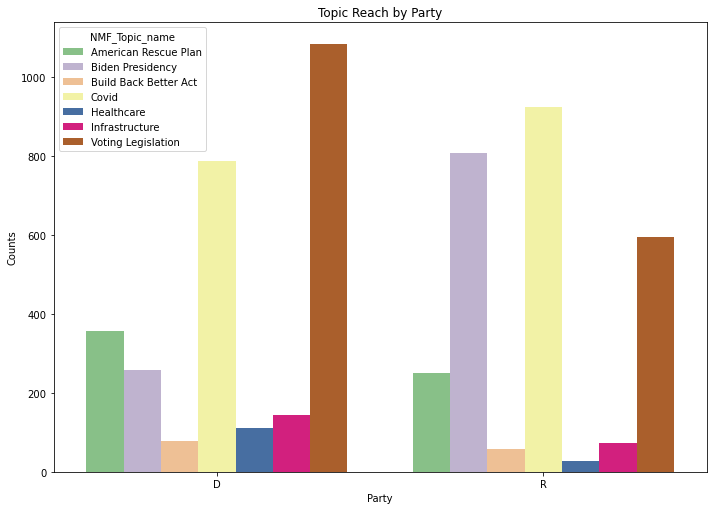

In [164]:
## Plotting Reach 

top_reach = df[df.Reach>5]

a4_dims = (11.7, 8.27)

#palette = ['tab:red', 'tab:blue', 'tab:green']

x = top_reach.groupby(['NMF_Topic_name','Party']).size().to_frame('Reach').reset_index()
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x='Party', y='Reach', hue='NMF_Topic_name', data=x,  palette='Accent').set(title='Topic Reach by Party')
ax.set(xlabel='Party', ylabel='Counts')
plt.show()

In [211]:
## make a backup of the df
df.to_pickle('pickles/df_with_reach.pickle')
df.to_csv('data/df_with_reach.csv', encoding='utf-8', index=False)

## Lets look at the topics and their sentiment scores

In [220]:
## Republicans
df[df.Party=='R'].groupby('NMF_Topic_name', as_index=False).agg(Polarity=('Polarity','mean'), 
                                            Compound= ('compound','mean'),
                                            Reach=('Reach','sum')).sort_values('Reach',ascending=False)

,NMF_Topic_name,Polarity,Compound,Reach
3,Covid,0.168992,0.241958,88237.5
1,Biden Presidency,0.010175,-0.130169,52831.0
6,Voting Legislation,0.095111,0.101531,41354.5
0,American Rescue Plan,0.059853,0.046947,24383.5
5,Infrastructure,0.108951,0.159856,10651.0
2,Build Back Better Act,0.151285,0.194882,5067.5
4,Healthcare,0.098707,0.213287,4694.0


In [222]:
## Democrats
df[df.Party=='D'].groupby('NMF_Topic_name', as_index=False).agg(Polarity=('Polarity','mean'), 
                                            Compound= ('compound','mean'),
                                            Reach=('Reach','sum')).sort_values('Reach',ascending=False)

,NMF_Topic_name,Polarity,Compound,Reach
3,Covid,0.170293,0.236002,127055.5
6,Voting Legislation,0.108495,0.123206,68327.5
0,American Rescue Plan,0.096555,0.181038,34636.5
5,Infrastructure,0.142306,0.239092,20022.5
4,Healthcare,0.118381,0.276057,18691.0
1,Biden Presidency,0.091025,0.067997,15144.5
2,Build Back Better Act,0.195808,0.381086,9433.0


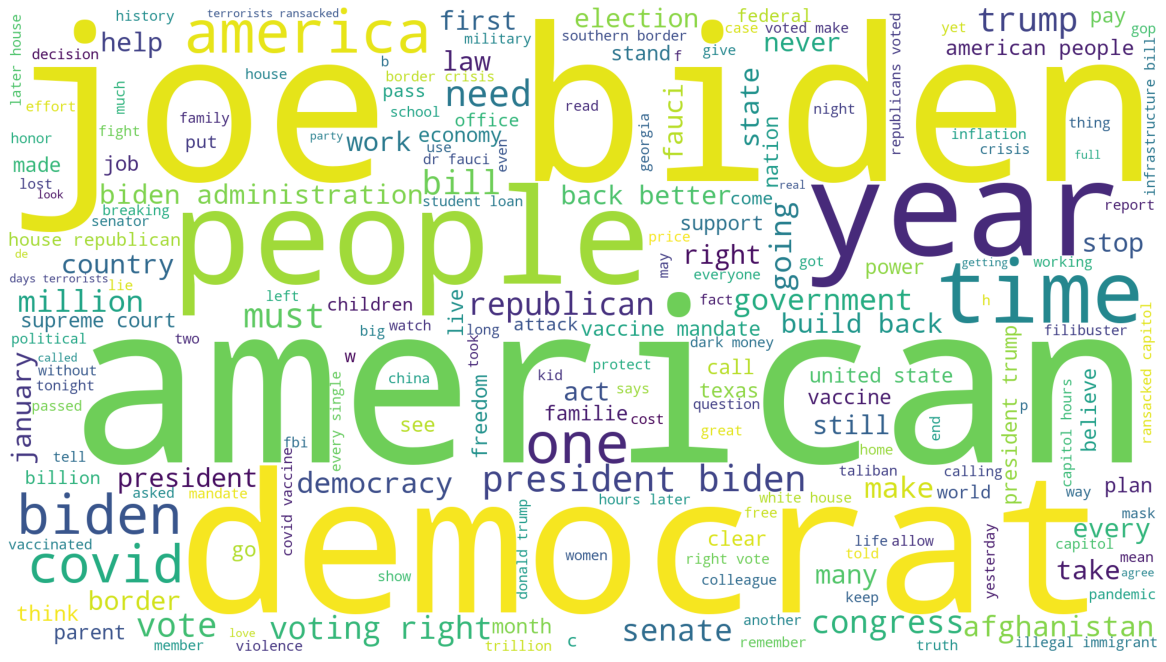

In [218]:
## World Cloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS

# Read dataframe
df_wc = pd.read_csv('data/df_with_reach.csv')
df_wc = df_wc[df_wc.Reach > 4]
comment_words = ''

wc_stopwords = {'live',
                'getting',
                'go',
                'see',
                'without',
                'long',
                'tell',
                'w',
                'c',
                'b',
                'de',
                'h',
                'p',}
stopwords.union(wc_stopwords)

stopwords = set(stopwords)

# iterate through the csv file
for val in df_wc.processed:
    
    # typecaste each val to string
    val = str(val)
    # split the value
    tokens = val.split()
    
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens)+" "


wordcloud = WordCloud(width = 1920, height = 1080,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (16, 9), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [1]:
df.groupby(['NMF_Topic_name','VADER_sentiment']).agg(Polarity=('Polarity','mean'), 
                                            Compound= ('compound','mean'),
                                            Reach=('Reach','sum')).sort_values('Reach',ascending=False)


NameError: name 'df' is not defined

In [209]:
#df = pd.read_csv('data/df_with_vader_textblob_scores.csv')


In [194]:
df.groupby(['NMF_Topic_name','Textblob_Sentiment'])[['Polarity','compound','Reach']].mean()

Polarity  compound     Reach
NMF_Topic_name        Textblob_Sentiment                              
American Rescue Plan  NEGATIVE           -0.220873 -0.194395  1.572978
                      NEUTRAL             0.000000  0.081760  1.476415
                      POSITIVE            0.281006  0.296453  1.422439
Biden Presidency      NEGATIVE           -0.292446 -0.369700  1.732020
                      NEUTRAL             0.000000 -0.085874  1.681857
                      POSITIVE            0.292136  0.117419  1.637357
Build Back Better Act NEGATIVE           -0.155782 -0.104237  1.553763
                      NEUTRAL             0.000000  0.065132  1.448519
                      POSITIVE            0.281167  0.448203  1.506163
Covid                 NEGATIVE           -0.242470 -0.132694  1.432428
                      NEUTRAL             0.000000  0.122956  1.294353
                      POSITIVE            0.399432  0.418183  1.244745
Healthcare            NEGATIVE           -0.183212 -0.020605  1.362126
                      NEUTRAL             0.000000  0.209483  1.307049
                      POSITIVE            0.309820  0.401422  1.287483
Infrastructure        NEGATIVE           -0.232255 -0.100022  1.439233
                      NEUTRAL             0.000000  0.121053  1.311795
                      POSITIVE            0.351435  0.377082  1.275615
Voting Legislation    NEGATIVE           -0.273283 -0.208855  1.731542
                      NEUTRAL             0.000000  0.066729  1.556489
                      POSITIVE            0.345543  0.276788  1.502520

In [195]:
df.groupby(['NMF_Topic_name','Textblob_Sentiment'])[['Polarity','compound']].mean()

Polarity  compound
NMF_Topic_name        Textblob_Sentiment                    
American Rescue Plan  NEGATIVE           -0.220873 -0.194395
                      NEUTRAL             0.000000  0.081760
                      POSITIVE            0.281006  0.296453
Biden Presidency      NEGATIVE           -0.292446 -0.369700
                      NEUTRAL             0.000000 -0.085874
                      POSITIVE            0.292136  0.117419
Build Back Better Act NEGATIVE           -0.155782 -0.104237
                      NEUTRAL             0.000000  0.065132
                      POSITIVE            0.281167  0.448203
Covid                 NEGATIVE           -0.242470 -0.132694
                      NEUTRAL             0.000000  0.122956
                      POSITIVE            0.399432  0.418183
Healthcare            NEGATIVE           -0.183212 -0.020605
                      NEUTRAL             0.000000  0.209483
                      POSITIVE            0.309820  0.401422
Infrastructure        NEGATIVE           -0.232255 -0.100022
                      NEUTRAL             0.000000  0.121053
                      POSITIVE            0.351435  0.377082
Voting Legislation    NEGATIVE           -0.273283 -0.208855
                      NEUTRAL             0.000000  0.066729
                      POSITIVE            0.345543  0.276788

In [193]:
df.groupby(['LDA_Topic_name','VADER_sentiment'])[['Polarity','compound']].mean()

Polarity  compound
LDA_Topic_name       VADER_sentiment                    
Biden Administration NEGATIVE        -0.048467 -0.461692
                     NEUTRAL          0.058769  0.000000
                     POSITIVE         0.182033  0.447116
Covid Relief         NEGATIVE        -0.039548 -0.440530
                     NEUTRAL          0.062665  0.000000
                     POSITIVE         0.259882  0.540442
Economy              NEGATIVE        -0.015700 -0.439209
                     NEUTRAL          0.055518  0.000000
                     POSITIVE         0.213854  0.513621
Family Support       NEGATIVE        -0.047245 -0.496083
                     NEUTRAL          0.032289  0.000000
                     POSITIVE         0.229427  0.545258
Help                 NEGATIVE        -0.016527 -0.448465
                     NEUTRAL          0.050455  0.000000
                     POSITIVE         0.226042  0.550694
Jobs                 NEGATIVE        -0.042071 -0.495792
                     NEUTRAL          0.050023  0.000000
                     POSITIVE         0.279016  0.566881
Legislation          NEGATIVE        -0.035687 -0.447269
                     NEUTRAL          0.042552  0.000000
                     POSITIVE         0.247498  0.540036